## **`Medical` Insurance Cost `Prediction`**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder , FunctionTransformer , KBinsDiscretizer
# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import pickle


In [3]:
df = pd.read_csv('F:\\PYTHON\\ML_Projects\\Medical_Insurance_Cost_Prediction\\data\\Raw\\insurance.csv')
df.sample(10)

,age,sex,bmi,children,smoker,region,charges
929,41,male,34.210,1,no,southeast,6289.75490
728,18,female,40.280,0,no,northeast,2217.60120
486,54,female,21.470,3,no,northwest,12475.35130
977,26,male,29.150,1,no,southeast,2902.90650
215,41,female,37.100,2,no,southwest,7371.77200
235,40,female,22.220,2,yes,southeast,19444.26580
616,56,female,28.595,0,no,northeast,11658.11505
876,49,female,27.100,1,no,southwest,26140.36030
1093,22,female,30.400,0,yes,northwest,33907.54800
45,55,male,37.300,0,no,southwest,20630.28351



---
## **`Profile`_Report**

In [ ]:
# Library for profile_report
from ydata_profiling import ProfileReport
df = pd.read_csv('F:\\PYTHON\\ML Projects\\Medical Insurance Cost Prediction\\data\\Raw\\insurance.csv')
prof = ProfileReport(df)
prof.to_file(output_file='Medical_Insurance_Cost_Prediction.html')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
# df.isnull().sum()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)


In [9]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



---
## **`Feature` Engineering**

In [10]:
print("Original shape:", df.shape)
df['smoker_binary'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

df['smoker_age'] = df['smoker_binary'] * df['age']
df['smoker_bmi'] = df['smoker_binary'] * df['bmi']
df['smoker_age_bmi'] = df['smoker_binary'] * df['age'] * df['bmi']
df['smoker_children'] = df['smoker_binary'] * df['children']

df['age_bmi'] = df['age'] * df['bmi']

df['age_children'] = df['age'] * df['children']
df['bmi_children'] = df['bmi'] * df['children']
df['age_squared'] = df['age'] ** 2
df['bmi_squared'] = df['bmi'] ** 2
df['bmi_category'] = pd.cut(df['bmi'], 
                             bins=[0, 18.5, 25, 30, 35, 100],
                             labels=['underweight', 'normal', 'overweight', 'obese_1', 'obese_2'])

df['age_group'] = pd.cut(df['age'],
                         bins=[0, 25, 35, 45, 55, 100],
                         labels=['18-25', '26-35', '36-45', '46-55', '55+'])

df['has_children'] = (df['children'] > 0).astype(int)

print(f"After feature engineering: {df.shape}")
print(f"Added {df.shape[1] - 7} new features!")

Original shape: (1337, 7)
After feature engineering: (1337, 20)
Added 13 new features!


In [11]:
df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_binary,smoker_age,smoker_bmi,smoker_age_bmi,smoker_children,age_bmi,age_children,bmi_children,age_squared,bmi_squared,bmi_category,age_group,has_children
0,19,female,27.900,0,yes,southwest,16884.92400,1,19,27.9,530.1,0,530.100,0,0.00,361,778.410000,overweight,18-25,0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0.0,0.0,0,607.860,18,33.77,324,1140.412900,obese_1,18-25,1
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0.0,0.0,0,924.000,84,99.00,784,1089.000000,obese_1,26-35,1
3,33,male,22.705,0,no,northwest,21984.47061,0,0,0.0,0.0,0,749.265,0,0.00,1089,515.517025,normal,26-35,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,0.0,0.0,0,924.160,0,0.00,1024,834.054400,overweight,26-35,0



---
## **`Eda` (Exploratory Data Analysis)** 

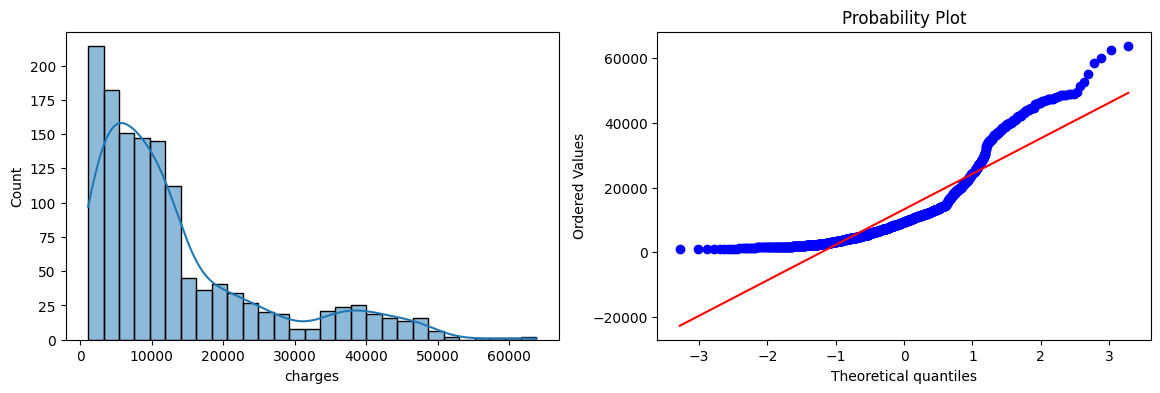

In [12]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.histplot(df['charges'],kde=True)
plt.subplot(122)
stats.probplot(df['charges'],dist='norm',plot=plt)
plt.show()

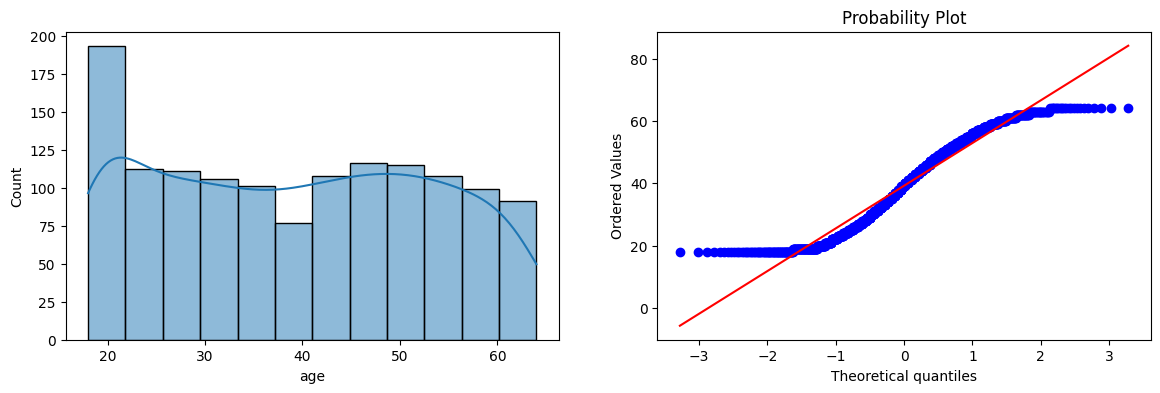

In [13]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.histplot(df['age'],kde=True)
plt.subplot(122)
stats.probplot(df['age'],dist='norm',plot=plt)
plt.show()

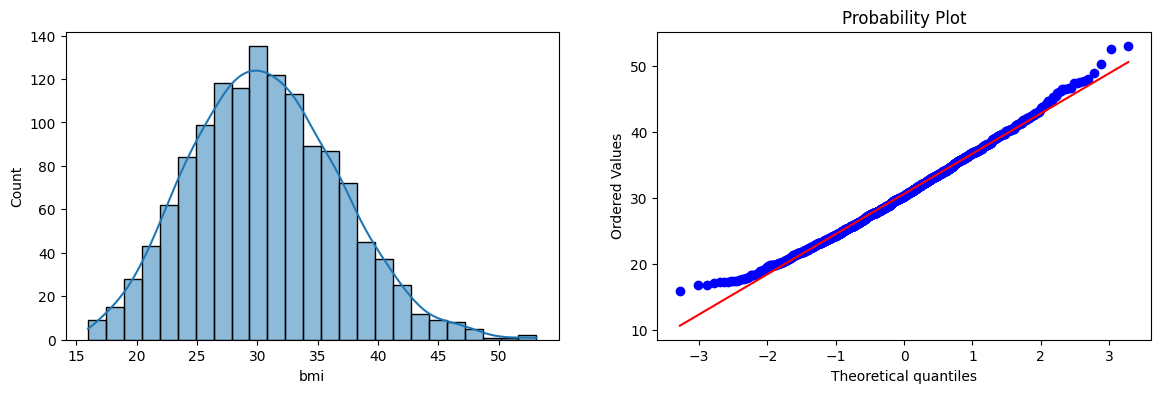

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.histplot(df['bmi'],kde=True)
plt.subplot(122)
stats.probplot(df['bmi'],dist='norm',plot=plt)
plt.show()

<Axes: xlabel='smoker', ylabel='charges'>

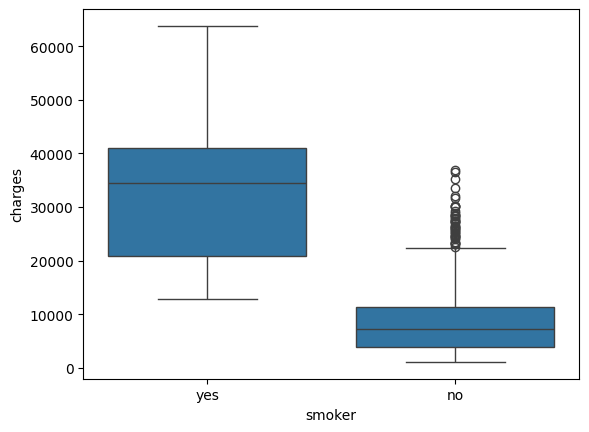

In [15]:
sns.boxplot(x='smoker',y='charges',data=df)

<Axes: xlabel='sex', ylabel='charges'>

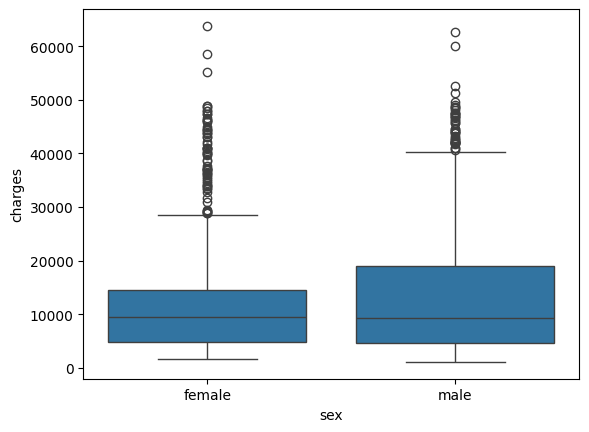

In [16]:
sns.boxplot(x='sex',y='charges',data=df)

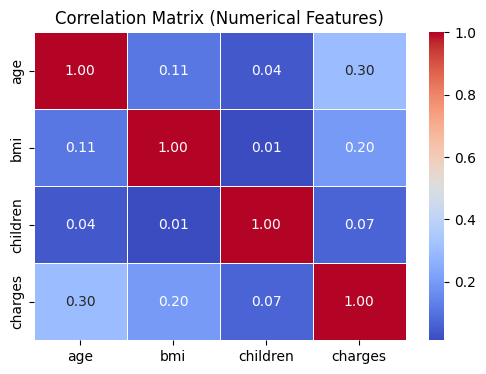

In [17]:
num_cols = ['age', 'bmi', 'children', 'charges']

corr = df[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

<Axes: xlabel='age', ylabel='charges'>

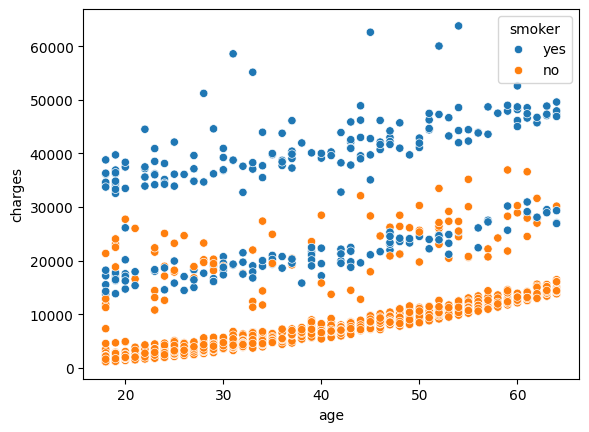

In [18]:
sns.scatterplot(x='age',y='charges',data=df,hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

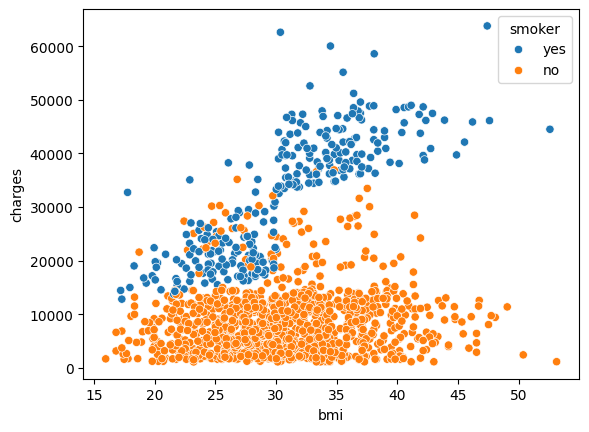

In [19]:
sns.scatterplot(x='bmi',y='charges',data=df,hue='smoker')

<Axes: xlabel='children', ylabel='charges'>

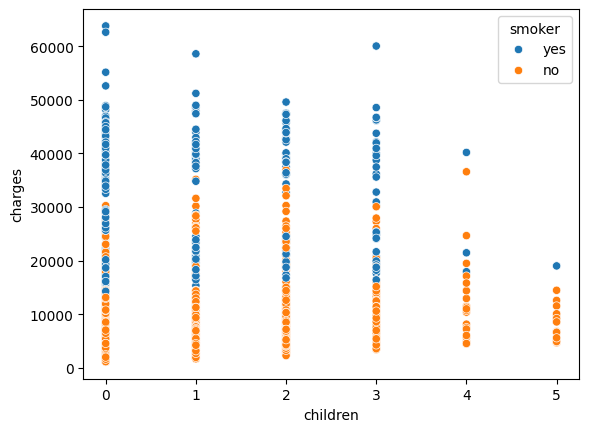

In [20]:
sns.scatterplot(x='children',y='charges',data=df,hue='smoker')

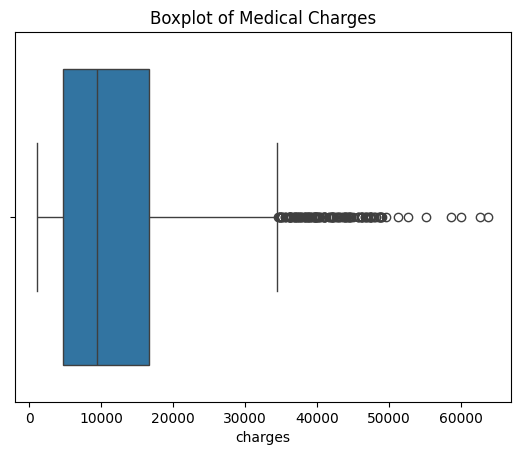

In [21]:
extreme_charges = df[df['charges'] > 50000]
extreme_charges[['age', 'bmi', 'children', 'smoker', 'charges']].sort_values('charges', ascending=False)
sns.boxplot(x=df['charges'])
plt.title("Boxplot of Medical Charges")
plt.show()


---
---
# **`Preprocessing`**

In [22]:
df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_binary,smoker_age,smoker_bmi,smoker_age_bmi,smoker_children,age_bmi,age_children,bmi_children,age_squared,bmi_squared,bmi_category,age_group,has_children
0,19,female,27.900,0,yes,southwest,16884.92400,1,19,27.9,530.1,0,530.100,0,0.00,361,778.410000,overweight,18-25,0
1,18,male,33.770,1,no,southeast,1725.55230,0,0,0.0,0.0,0,607.860,18,33.77,324,1140.412900,obese_1,18-25,1
2,28,male,33.000,3,no,southeast,4449.46200,0,0,0.0,0.0,0,924.000,84,99.00,784,1089.000000,obese_1,26-35,1
3,33,male,22.705,0,no,northwest,21984.47061,0,0,0.0,0.0,0,749.265,0,0.00,1089,515.517025,normal,26-35,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0,0.0,0.0,0,924.160,0,0.00,1024,834.054400,overweight,26-35,0


In [23]:
x = df.drop(['charges', 'smoker_binary'], axis=1)
y = df['charges']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42,
    stratify=df['smoker']  # Ensure same smoker ratio in train/test
)

x_train['smoker'].unique()


array(['no', 'yes'], dtype=object)

In [24]:
x_train['smoker'].unique()

array(['no', 'yes'], dtype=object)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to create all engineered features
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        
        # Binary smoker
        X_['smoker_binary'] = X_['smoker'].map({'no':0, 'yes':1})
        
        # Interactions
        X_['smoker_age'] = X_['smoker_binary'] * X_['age']
        X_['smoker_bmi'] = X_['smoker_binary'] * X_['bmi']
        X_['smoker_age_bmi'] = X_['smoker_binary'] * X_['age'] * X_['bmi']
        X_['smoker_children'] = X_['smoker_binary'] * X_['children']
        X_['age_bmi'] = X_['age'] * X_['bmi']
        X_['age_children'] = X_['age'] * X_['children']
        X_['bmi_children'] = X_['bmi'] * X_['children']
        X_['age_squared'] = X_['age'] ** 2
        X_['bmi_squared'] = X_['bmi'] ** 2
        X_['has_children'] = (X_['children'] > 0).astype(int)
        
        # Categories
        X_['bmi_category'] = pd.cut(
            X_['bmi'], bins=[0, 18.5, 25, 30, 35, 100],
            labels=['underweight','normal','overweight','obese_1','obese_2']
        )
        X_['age_group'] = pd.cut(
            X_['age'], bins=[0, 25, 35, 45, 55, 100],
            labels=['18-25','26-35','36-45','46-55','55+']
        )
        
        return X_


In [26]:
# Categorical features
cat = ['sex', 'region', 'bmi_category', 'age_group']
ord = ['smoker']
num_cols = [
    'bmi', 'children', 'age',
    'smoker_age', 'smoker_bmi', 'smoker_age_bmi', 'smoker_children',
    'age_bmi', 'age_children', 'bmi_children',
    'age_squared', 'bmi_squared',
    'has_children'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), cat),
        ('ord', OrdinalEncoder(categories=[['no','yes']]), ord),
        ('num', 'passthrough', num_cols)
    ]
)

x_train_trf = preprocessor.fit_transform(x_train)
x_test_trf = preprocessor.transform(x_test)

In [27]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(x_train_trf,columns=feature_names)
print(f"\nTotal features after preprocessing: {X_train_df.shape[1]}")
X_train_df.head()


Total features after preprocessing: 26


,ohe__sex_male,ohe__region_northwest,ohe__region_southeast,ohe__region_southwest,ohe__bmi_category_obese_1,ohe__bmi_category_obese_2,ohe__bmi_category_overweight,ohe__bmi_category_underweight,ohe__age_group_26-35,ohe__age_group_36-45,...,num__smoker_age,num__smoker_bmi,num__smoker_age_bmi,num__smoker_children,num__age_bmi,num__age_children,num__bmi_children,num__age_squared,num__bmi_squared,num__has_children
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1049.37,84.0,49.97,1764.0,624.250225,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2506.24,64.0,39.16,4096.0,1533.505600,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1562.44,0.0,0.00,2809.0,869.070400,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1339.03,0.0,0.00,1369.0,1309.716100,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,689.04,0.0,0.00,324.0,1465.358400,0.0


## **Log `Transformation` on `Output` Column**

In [28]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

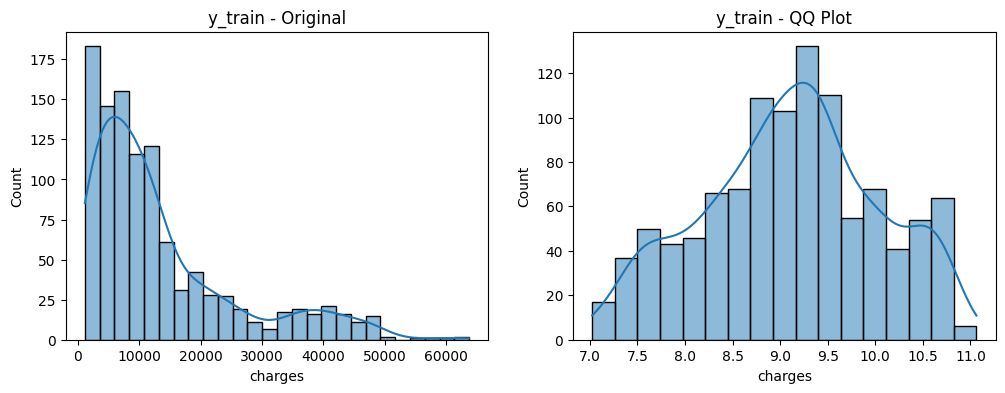

In [29]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(y_train, kde=True)
plt.title("y_train - Original")

plt.subplot(1,2,2)
sns.histplot(y_train_log, kde=True)
plt.title("y_train - QQ Plot")

plt.show()

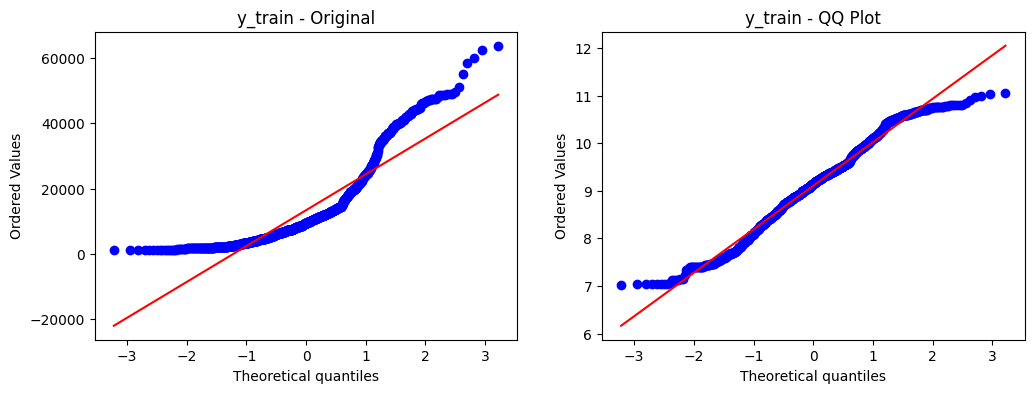

In [30]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
stats.probplot(y_train, dist='norm', plot=plt)
plt.title("y_train - Original")

plt.subplot(1,2,2)
stats.probplot(y_train_log, dist='norm', plot=plt)
plt.title("y_train - QQ Plot")

plt.show()


---
### **Saving `Cleaned` Dataset**

In [31]:
X_train_clean = pd.DataFrame(preprocessor.transform(x_train), columns=preprocessor.get_feature_names_out())
X_test_clean  = pd.DataFrame(preprocessor.transform(x_test),  columns=preprocessor.get_feature_names_out())

X_train_clean['charges']     = y_train.values
X_train_clean['charges_log'] = np.log1p(y_train.values)
X_train_clean['is_train']    = 1  

X_test_clean['charges']      = y_test.values
X_test_clean['charges_log']  = np.log1p(y_test.values)
X_test_clean['is_train']     = 0  

combined_df = pd.concat([X_train_clean, X_test_clean], axis=0).reset_index(drop=True)
combined_df.to_csv(
    r"F:\PYTHON\ML_Projects\Medical_Insurance_Cost_Prediction\data\Processed\cleaned_dataset.csv",index=False)
print("Combined dataset saved with shape:", combined_df.shape)

Combined dataset saved with shape: (1337, 29)


In [32]:
pd.read_csv(r"F:\PYTHON\ML_Projects\Medical_Insurance_Cost_Prediction\data\Processed\cleaned_dataset.csv").head()

,ohe__sex_male,ohe__region_northwest,ohe__region_southeast,ohe__region_southwest,ohe__bmi_category_obese_1,ohe__bmi_category_obese_2,ohe__bmi_category_overweight,ohe__bmi_category_underweight,ohe__age_group_26-35,ohe__age_group_36-45,...,num__smoker_children,num__age_bmi,num__age_children,num__bmi_children,num__age_squared,num__bmi_squared,num__has_children,charges,charges_log,is_train
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1049.37,84.0,49.97,1764.0,624.250225,1.0,8017.06115,8.989452,1
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2506.24,64.0,39.16,4096.0,1533.505600,1.0,14418.28040,9.576322,1
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1562.44,0.0,0.00,2809.0,869.070400,0.0,9487.64420,9.157851,1
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1339.03,0.0,0.00,1369.0,1309.716100,0.0,19214.70553,9.863483,1
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,689.04,0.0,0.00,324.0,1465.358400,0.0,14133.03775,9.556341,1



---
# **`Model` Traning & `Evaluation`**


---
## **Linear `Regresssion`**

In [33]:
lr = LinearRegression()
lr.fit(x_train_trf, y_train_log)
y_pred_log = lr.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Linear Regression - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")


Linear Regression - R2: 0.8766 | MAE: $2,279.57 | RMSE: $4,217.06


## **Ridge `Regression`**

In [34]:
rd = Ridge()
rd.fit(x_train_trf, y_train_log)
y_pred_log = rd.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Ridge Regression - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Ridge Regression - R2: 0.8735 | MAE: $2,285.33 | RMSE: $4,269.66



---
## **`Lasso` Regression**

In [35]:
ls = Lasso()
ls.fit(x_train_trf, y_train_log)
y_pred_log = ls.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Lasso Regression - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Lasso Regression - R2: 0.6252 | MAE: $3,691.84 | RMSE: $7,350.03



---
## **`Elastic` Net Regression**

In [36]:
els = ElasticNet()
els.fit(x_train_trf, y_train_log)
y_pred_log = els.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"ElasticNet Regression - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

ElasticNet Regression - R2: 0.7999 | MAE: $2,868.48 | RMSE: $5,371.01



---
## **`Decision Tree` Regressor**

In [37]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train_trf, y_train_log)
y_pred_log = dt.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Decision Tree - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Decision Tree - R2: 0.7826 | MAE: $2,494.58 | RMSE: $5,598.67



---
## **`Extra Trees` Regressor**

In [38]:
ex = ExtraTreesRegressor(random_state=42, n_jobs=1)
ex.fit(x_train_trf, y_train_log)
y_pred_log = ex.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Extra Trees - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Extra Trees - R2: 0.8819 | MAE: $2,105.95 | RMSE: $4,126.54



--- 
## **`GradientBoosting` Regressor**

In [39]:
gb_reg = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb_reg.fit(x_train_trf, y_train_log)
y_pred_log = gb_reg.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Gradient Boosting - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Gradient Boosting - R2: 0.8842 | MAE: $2,124.93 | RMSE: $4,085.34



---
## **`AdaBoost` Regressor**

In [40]:
ad = AdaBoostRegressor(n_estimators=200, random_state=42)
ad.fit(x_train_trf, y_train_log)
y_pred_log = ad.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"AdaBoost - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

AdaBoost - R2: 0.8957 | MAE: $3,016.66 | RMSE: $3,877.30



---
## **`SVR`**

In [41]:
sv = SVR()
sv.fit(x_train_trf, y_train_log)
y_pred_log = sv.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"SVR - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

SVR - R2: 0.8540 | MAE: $2,091.48 | RMSE: $4,587.51



---
## **`KNN`**

In [42]:
knn = KNeighborsRegressor()
knn.fit(x_train_trf, y_train_log)
y_pred_log = knn.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"KNN - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

KNN - R2: 0.9051 | MAE: $1,983.19 | RMSE: $3,697.76



---
## **`MLP` Regressor**

In [43]:
mlp = MLPRegressor(max_iter=1000, random_state=42)
mlp.fit(x_train_trf, y_train_log)
y_pred_log = mlp.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MLP - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

MLP - R2: -64.2322 | MAE: $28,354.34 | RMSE: $96,972.10



---
## **`LightGBM` Regressor**

In [44]:
import lightgbm
lg_bm = lightgbm.LGBMRegressor(n_estimators=1000,learning_rate=0.03,num_leaves=31,max_depth=-1)

lg_bm.fit(x_train_trf, y_train_log)
y_pred_log = lg_bm.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"LightGBM - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 25
[LightGBM] [Info] Start training from score 9.106573
LightGBM - R2: 0.8885 | MAE: $2,348.80 | RMSE: $4,008.53


c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



---
## **`CatBoost` Regressor**

In [45]:
ct_reg = CatBoostRegressor(iterations=500, random_state=42, verbose=0, thread_count=1)
ct_reg.fit(x_train_trf, y_train_log)
y_pred_log = ct_reg.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"CatBoost - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

CatBoost - R2: 0.8871 | MAE: $2,179.42 | RMSE: $4,033.65



---
## **`XGBoost` Regressor**

In [46]:
xgb_model = xgb.XGBRegressor(n_estimators=500, random_state=42, n_jobs=1)
xgb_model.fit(x_train_trf, y_train_log)
y_pred_log = xgb_model.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"XGBoost - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

XGBoost - R2: 0.8210 | MAE: $2,786.57 | RMSE: $5,079.80



---
## **`RandomForest` Regressor**

In [47]:
rf_reg = RandomForestRegressor(n_estimators=200,max_depth=20,min_samples_leaf=3,
                           max_features='sqrt', random_state=42, n_jobs=1)

rf_reg.fit(x_train_trf, y_train_log)
y_pred_log = rf_reg.predict(x_test_trf)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest - R2: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

Random Forest - R2: 0.9246 | MAE: $1,536.05 | RMSE: $3,296.82


---

## **`Random Forest` has higher `R2_Score`**

In [49]:
import pickle

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),  # handles all raw features
        ('model', rf_reg)                # trained model
        ])
rf_pipeline.fit(x_train, y_train_log)

with open(r"F:\\PYTHON\\ML_Projects\\Medical_Insurance_Cost_Prediction\\models\\model.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)
print("Pipeline with preprocessing saved successfully!")

Pipeline with preprocessing saved successfully!
